# EE551 Embedded Image Processing
## Assignment 1 - Image Signal Processor (ISP)

### Background
An ISP is a processing block that converts raw sensor images into a colour array. There is a surprising amount of image processing that occurs between image capture and output colour images. In this assignment, you will implement a basic ISP.

You will be provided with samples of binary files containing raw sensor images (details of how to read these image files will be provided). The task is then to convert this raw data into a colour image.

The following processing will be done:
- Read in the image
- Demosaic (convert raw to RGB)
- Apply Colour Correction Matrix (matrix will be provided)
- Apply Denoise (e.g. bilateral filter)
- Apply Edge Enhancement (e.g. unsharp mask)
- Apply Contrast Enhancement (e.g. CLAHE)
- Save result to an output file

## Submission Details
Assignment deadline: Midnight, Friday 10th Feb \
Jupyter Notebook containing submission to be submitted via blackboard \
Total grade: 10% of final module mark 


# Submission details:
#### Name: Shubham Kumar Manglam
#### ID: 20230220
#### Class code: 1MAI

In [1]:
# Useful libraries
%matplotlib inline
import os
import os.path as op

import numpy as np
import cv2
from skimage import exposure
from scipy import ndimage
import matplotlib.pylab as plt


## Read in the raw image file

For this assignment, a raw image file will be provided. This is an image of a photographic test target. The pixel data
is stored as unsigned integers, 8 bits per pixel. The code for reading the image will be provided.

The general process is to read in the binary information, then reshape the array into the image dimensions (in this case, 4096*2160 pixels)


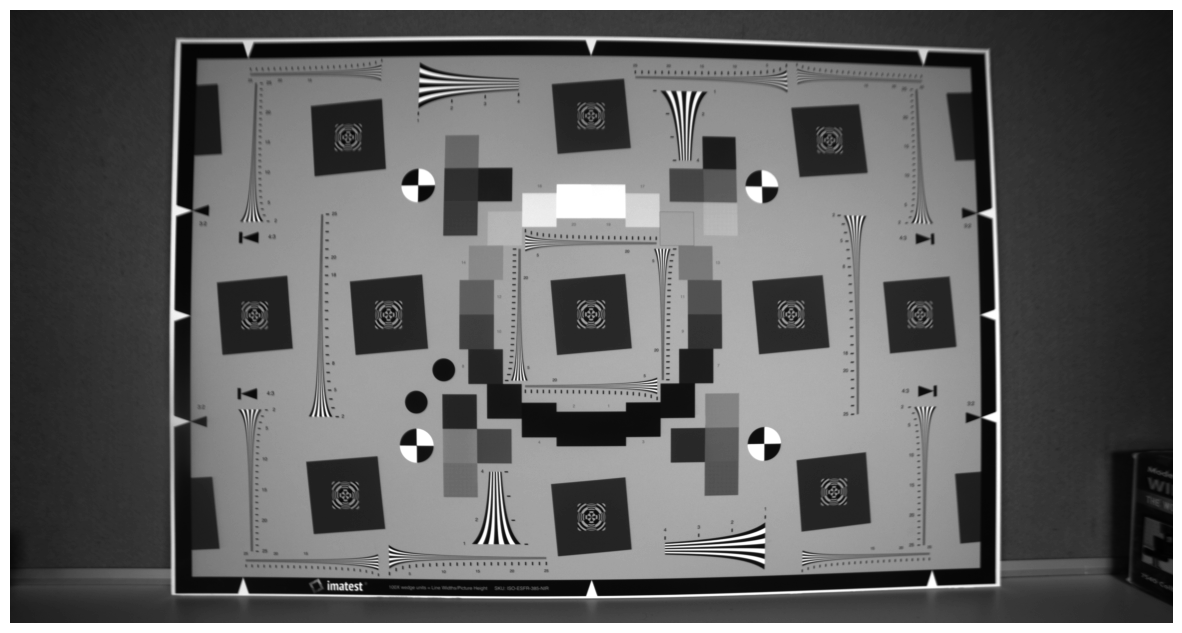

In [2]:
# Read in the file

# Raw file details:
# width - 4096
# height - 2160
# bit depth - 8
# Bayer pattern - rggb


bayer_width = 4096
bayer_height = 2160

raw_path = 'chart.raw'

bayer = np.fromfile(raw_path, dtype='uint8', sep='')

bayer = bayer.reshape((bayer_height, bayer_width))

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()


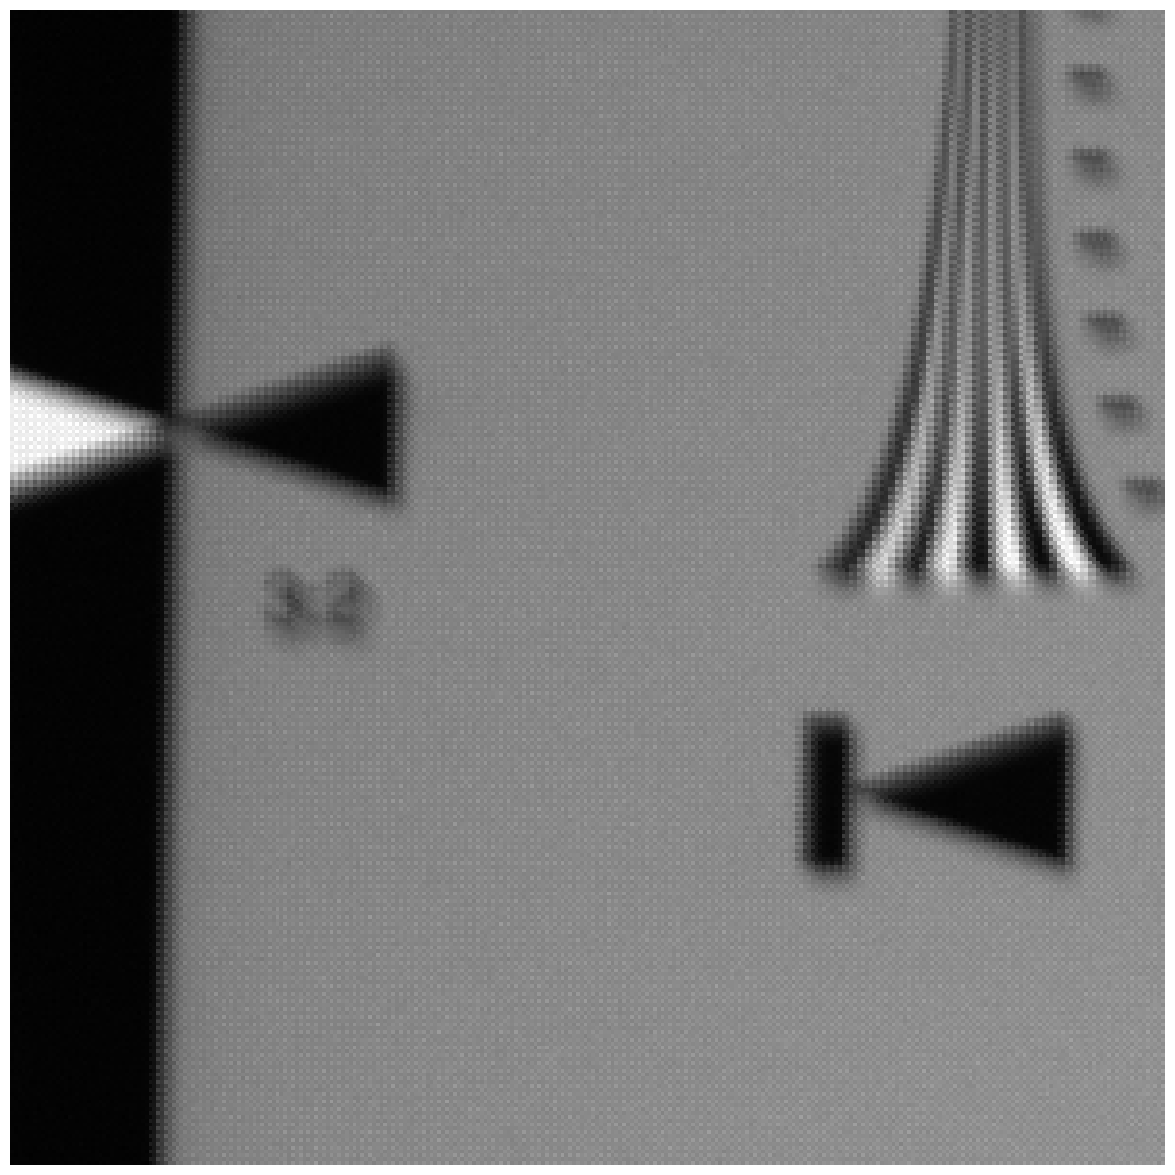

In [3]:
# crop and show a small area, to show the Bayer raw pattern

bayer_crop = bayer[600:900, 600:900] 

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer_crop,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

## Demosaic the image
The demosaic process converts raw pixel data into RGB image data. Each raw sensor pixel contains only one colour. Part of the demosaic process is to use interpolation to generate the missing colours for each pixel (i.e. a red pixel will get green and blue pixel information from the neighbouring pixels

Hint: use the opencv "cvtColor" function. This function can be used to convert between many colour spaces. For this assignment, you'll want the "COLOR_BAYER_RG2BGR" option. 

more general details are available here: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

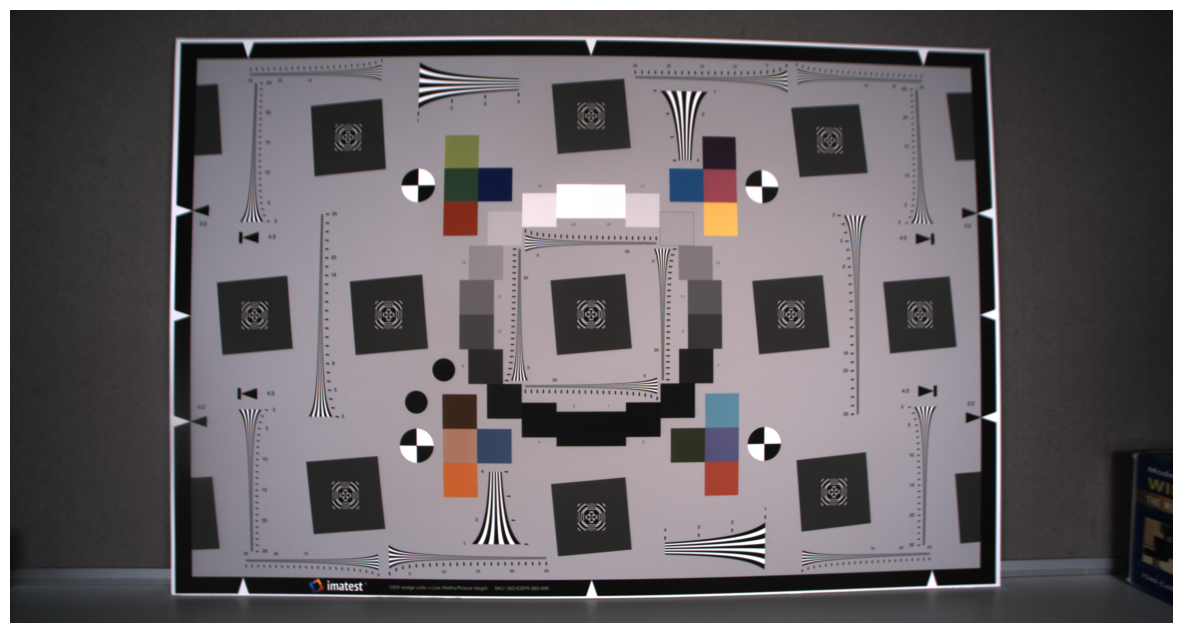

In [4]:
# Demosaic the image (i.e. covert from raw image to RGB)

debayer =  cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)



# plot the resulting raw file inline

plt.figure(figsize=(15,15))
plt.imshow(debayer)
plt.axis('off')
plt.show()


## Apply colour correction

A colour correction matrix is applied to improve colour reproduction accuracy. If you notice, red appears too orange before
correction is applied.

The colour correction matrix (CCM) is calculated during the camera development phase, and varies from camera to camera.

For simplicity, the CCM for this particular camera is provided below:
    
    [[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]]
    
 
 This 3*3 matrix is multiplied by the RGB values for every pixel
 
 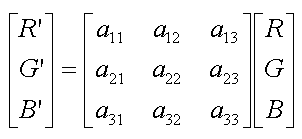
 
 
 
 Note that for embedded applications, floating point numbers are avoided wherever possible. In this example, the base is 1024 (i.e. to convert to floating point, divide the CCM by 1024)
 
 To apply the CCM in this example, the following steps are required:
 - cast the image to np.int32
 - multiply the RGB pixel data by the 3*3 CCM
 - divide by 1024
 - re-cast the image back to np.uint8
    

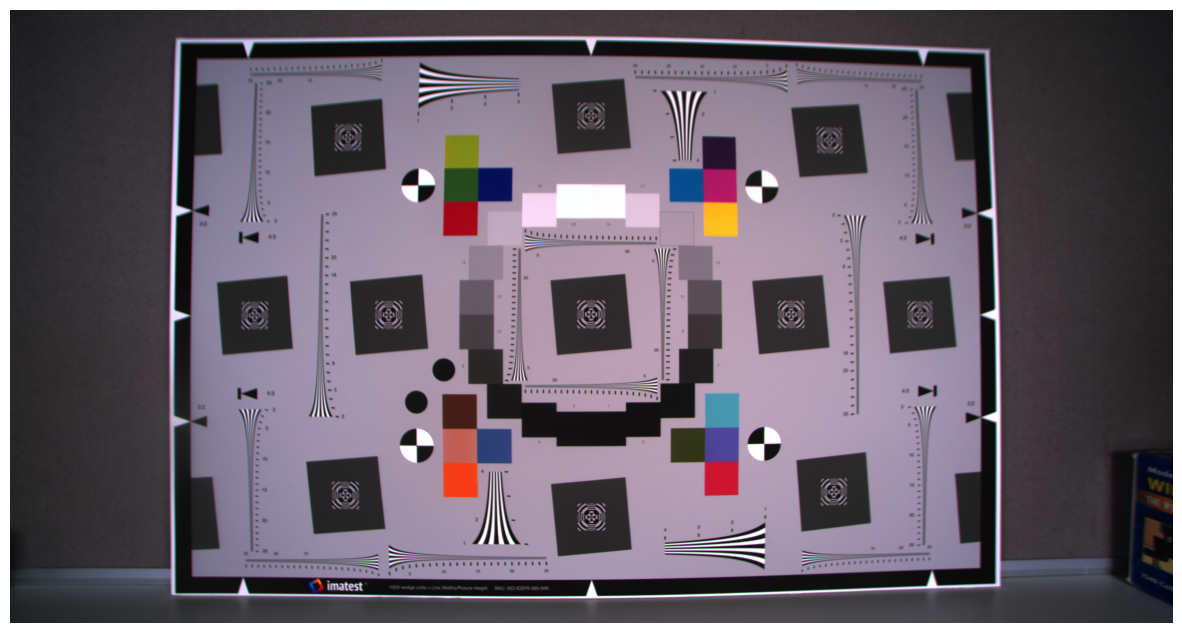

In [5]:
# apply colour correction matrix
# note: to avoid clipping, we have to temporarily cast our image data to uint32, and then return to 8 bit

# hint - cast the ccm array and image as np.int32
# multiply the image by the ccm matrix, and then use np.right_shift to scale the image down to the 8 bit range again
# use the np.clip function to ensure the data range is within 0 and 255

ccm = np.array([[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]],dtype=np.int32).T
cast_img = debayer.astype(np.uint32)
mul_img = np.matmul(cast_img,ccm)
mul_img = mul_img/1024
cast_img = np.clip(mul_img,0, 255).astype(np.uint8)


# plot the resulting raw file inline

plt.figure(figsize=(15,15))
plt.imshow(cast_img)
plt.axis('off')
plt.show()

## Apply gamma correction

Gamma correction is applied using the following formula:

$$
outputImage = ((inputImage / 255)^\gamma) * 255
$$

Typically, $$\gamma=1/2.2$$


hint - use numpy clip function to ensure the data range is within 0 and 255

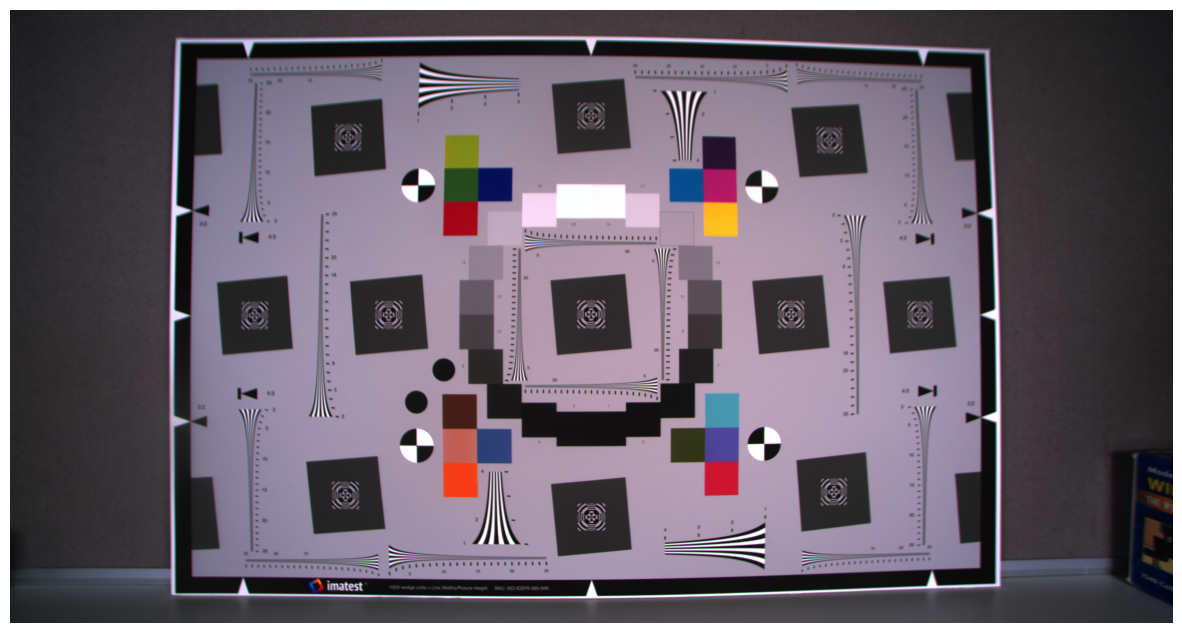

In [6]:
# apply gamma correction
gamma= 1/2.2
in_img = cast_img//255
op_img =(in_img** gamma) *255
op_img=np.clip(mul_img,0, 255).astype(np.uint8)

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(op_img)
plt.axis('off')
plt.show()


## Apply denoise to image

For this block, it is up to the student to decide which denoise block to use (there are several options available). 

One good option would be openCV's bilateral filter

Hint - experiment with parameters, examine the effect of different parameters on the image. There isn't necessarily a right or wrong configuration, but changing the parameters will have an impact on the final image

In [ ]:
# apply image denoise filtering (bilateral filter)
# hint - use opencv cv2.bilateral filter

# experiment with filter coefficients to see the impact on the image. It might help to crop on an area to get the full effect
b_blur=cv2.bilateralFilter(op_img, 200, 80, 80)

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(b_blur)
plt.axis('off')
plt.show()

## Apply edge enhancement

Apply edge enhancement to the image. Again, it is up to the student to select the edge enhancement approach used (we covered a few options in class)

Again, vary the parameters and see the impact on the image

In [7]:
# apply edge enhancement
# hint: implement Laplacian or unsharp mask filtering from previous course material. 



# plot the resulting raw file inline


## Apply contrast enhancement

Finally, apply contrast enhancement to the image. It is up to the student to select the contrast enhancement used. One option would be adaptive histogram equalization, covered earlier in the module (check out the skimage exposure library). And again, vary the parameters to examine the effect on the final image

In [8]:
# increase image contrast. Hint - check out skimage exposure

# plot the resulting raw file inline
